
## Kaggle Whale Id 

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from skimage.io import imread
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.listdir("../input/")

['train', 'test', 'train.csv', 'sample_submission.csv']

In [3]:
train_df = pd.read_csv("../input/train.csv")

Let's see some whale images that we have.

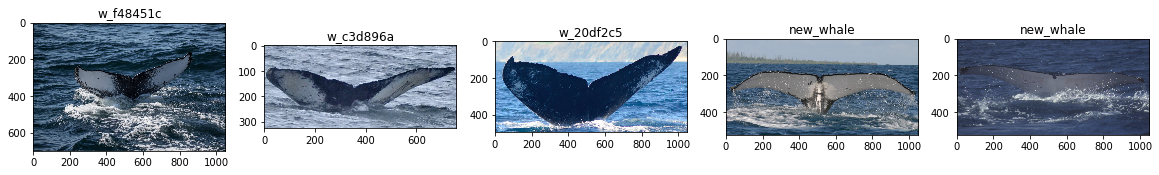

In [4]:
img_path = '../input/train/'

#get the first 5 whale images
images = [(whale_img, whale_label) for (whale_img, whale_label) in zip(train_df.Image[:5], train_df.Id[:5])]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(imread(os.path.join(img_path,images[ii][0])))
    c_ax.set_title(images[ii][1])

The problem in this dataset is that there are 5005 kinds of whales (including the category new_whale). Since there are about 25k images, this gives us about 5 images of each whale on average, which is an extremely low number to train a model.

In [5]:
#how many photos of each whale
train_df.Id.value_counts()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
w_2b069ba      48
w_d405854      47
w_789c969      45
w_f0fe284      45
w_778e474      40
w_343f088      40
w_5e8e218      40
w_60ce6fc      37
w_5a2634c      37
w_a9304b9      37
w_6822dbc      36
w_af367c3      35
w_f765256      34
w_1ca9ab1      34
w_17b0d3a      33
w_d72771c      32
w_08630fd      31
w_8c25681      31
w_6cda039      31
w_51fc1fc      30
             ... 
w_e329a65       1
w_f57fb81       1
w_81d807a       1
w_17ba5e4       1
w_08eadf6       1
w_f1cd92c       1
w_257e223       1
w_060ec6d       1
w_658f76d       1
w_08d5864       1
w_f11cbbc       1
w_17e8846       1
w_3ad0f37       1
w_a48fa24       1
w_8ace2d9       1
w_50260e7       1
w_49cd60d       1
w_ab02160       1
w_45a0a22       1
w_38fc953       1
w_d9993ee       1
w_48b1730       1
w_cf31c86       1
w_60795e6       1
w_ec1eb03 

Several whales have been spotted considerably more times than others. Moreover, 9664 whales in the training dataset are actually non-identified whales. There are also many classes with only one image. I believe that correctly identifying (i.e. guessing a photo is one of them with a higher probability) those ones will set the best score 

# Training models using generators and flow_from_dataframe <a name="flow"></a>
____

In order to avoid using consuming so much memory, we will make use of the `fit_generator` method in our model. To use it, we have three options to get and train our data: `flow`, `flow_from_dataframe` and `flow_from_directory`.   [Here](https://keras.io/preprocessing/image/#imagedatagenerator-class/) you can check the full documentation and their arguments. 

The first method, `flow` is used when we already have all the data we need available in memory. Here, however, we only have the image's location in memory right now, and we don't want to load all images at the same time to avoid extra memory consumption. Therefore we won't use `flow`. 

The second one, `flow_from_dataframe` will be very useful to us. It checks the path available on the dataframe and then automatically search for the image in train directory. Then it make the desired preprocessing steps available in `ImageDataGenerator`. 

The last method, `flow_from_directory`, will be used during testing, since we don't have a dataframe containing all the image's paths to the test set. This method looks inside the directory and get `batch_size` images to make the classification. 

In order to use `flow_from_directory` in our test data, we can't just use 
```python 
'../input/test/' 
``` 
because the the folders need to be arranged in the following format:

![directory_formta](https://cdn-images-1.medium.com/max/1000/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)
[Source](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720)

So we will need to create a folder that contains a folder that contains our images. This will make our generator recognize that there is one class of images in the test dataset (think of it as an "unlabeled" class) so then we can get this data and use our classifier to predict their classes. Let's do this now.


In [6]:
import os
from distutils.dir_util import copy_tree

#create directories
os.mkdir('test_folder')
os.mkdir('test_folder/test_images')

# copy subdirectory example
fromDirectory = "../input/test"
toDirectory = "test_folder/test_images"

copy_tree(fromDirectory, toDirectory, verbose=0)

['test_folder/test_images/f28e2a7e7.jpg',
 'test_folder/test_images/6d792e3e6.jpg',
 ...]

In [7]:
''' 
make sure all preprocessing done in the training 
image generator is done in test generator as well
'''

# validation_split sets the percentage of data generated
# to be used in validation phase
datagen=image.ImageDataGenerator(rescale=1./255, validation_split = 0.1)
test_datagen = image.ImageDataGenerator(rescale=1./255) 

'''
Comments:
- ImageDataGenerator will resize all images to target_size
- x_col is the column where the images' names are
- y_col is the column where the labels are
- has_ext means that the images' names include a file extension, e.g. image_name.jpg
- Here you can change the targe_size to resize all images to different shapes.
Maybe larger images help in getting a better accuracy
'''

# since the datagen is splitted in training and validation,
# make sure to set subsets correctly

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df, directory="../input/train/", 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(100,100), batch_size=32, subset = "training")

validation_generator = datagen.flow_from_dataframe(dataframe=train_df, directory="../input/train/", 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(100,100), batch_size=32, subset = "validation")

# make sure shuffle is set to false, so the predictions are done on the same order
# as they appear on the directory. batch_size should be 1 to make the
# predictions image by image

test_generator = test_datagen.flow_from_directory(directory="test_folder", 
    seed = 42, class_mode=None, target_size=(100,100), batch_size=1, shuffle = False)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 22825 images belonging to 5005 classes.
Found 2536 images belonging to 5005 classes.
Found 7960 images belonging to 1 classes.


Build, compile and train the model use, a simple Convolutional layer, Dropout and GlobalMaxPooling for simplicity Make sure `input_shape` from Conv2D is the same that `target_size` in the generators.

In [8]:
from keras.metrics import top_k_categorical_accuracy

''' the function top_5_accuracy is from Peter's kernel:
    https://www.kaggle.com/pestipeti/keras-cnn-starter
'''
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (100, 100, 3)))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling2D()) 
# model.add(Flatten())
model.add(Dense(5005, activation = 'softmax'))
# model.summary()

model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2, callbacks = [checkpointer, early_stopping])

Epoch 1/2
713/713 [==============================] - 290s 407ms/step - loss: 6.2225 - acc: 0.3703 - top_5_accuracy: 0.3793 - val_loss: 6.7987 - val_acc: 0.3908 - val_top_5_accuracy: 0.3999

Epoch 00001: val_loss improved from inf to 6.79867, saving model to weights.hdf5
Epoch 2/2
713/713 [==============================] - 250s 350ms/step - loss: 5.7026 - acc: 0.3798 - top_5_accuracy: 0.3887 - val_loss: 6.7602 - val_acc: 0.3950 - val_top_5_accuracy: 0.4050

Epoch 00002: val_loss improved from 6.79867 to 6.76018, saving model to weights.hdf5


In [9]:
#Use .reset() here otherwise
#the other of predictions will be different
#then the expected
test_generator.reset()
pred = model.predict_generator(test_generator,verbose = 1,steps=7960)

7960/7960 [==============================] - 91s 11ms/step


In [10]:
'''This filters only the top 5 possible ids of an image'''
pred_sorted = np.argsort(-pred, axis = 1)[:,:5]
pred_sorted

array([[  3, 265, 166,  18,  58],
       [  3, 265, 166,  18,  58],
       [  3, 265, 166,  18,  58],
       ...,
       [  3, 265, 166,  18,  58],
       [  3, 265, 166,  18,  58],
       [  3, 265, 166,  18, 169]])

the model overfits. Indexes 3, 265 and 166 are the most common indexes in our training dataset (3 is new_whale). Need to generate more images  
Some basic augmentation can be done within `ImagedataGenerator`. Check the [documentation](https://keras.io/preprocessing/image/) for some ideas!

Now let's proceed to the final steps. 

In [11]:
'''
Now we generate a map of each 
index to an Id on the format 
{
0: 'w_f48451c',
1: 'w_c3d896a',
2: 'w_20df2c5',
...
}
'''
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [12]:
'''
Here we prepare pred_ids, which is a list of lists containing 
the top 5 ids by name. For example, w_13ae3d4. 
'''
from tqdm import tqdm
#create empty list
pred_ids = list()
for i,row in enumerate(tqdm(pred_sorted)):
    #create a temporary list to store the ids for a given image
    temp_list = []
    for j,value in enumerate(row):
        #for each index in pred_sorted, append the real Id in temp_list
        temp_list.append(labels[row[j]])
    #append all 5 ids for a given image to pred_ids
    #effectively creating a similar list to pred_sorted
    #but with the real ids
    pred_ids.append(temp_list)

100%|██████████| 7960/7960 [00:00<00:00, 204244.73it/s]


In [13]:
'''create the final predictions by using all ids in a single string'''
final_preds = []
for i,top_5_ids in enumerate(pred_ids):
    final_preds.append(' '.join(pred_ids[i]))

In [14]:
'''delete the files on disk - otherwise the Kaggle kernel will throw an error'''
import shutil
shutil.rmtree('test_folder', ignore_errors=True)

In [15]:
submission = pd.DataFrame({"Image": os.listdir('../input/test'), "Id": final_preds})
submission.to_csv("submission.csv", index = False)
submission.head()

,Image,Id
0,f28e2a7e7.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
1,f1a620ed9.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
2,1613db994.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
3,dac7f10b4.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_0369a5c
4,777e2025a.jpg,new_whale w_9b5109b w_23a388d w_9c506f6 w_d405854
